In [1]:
!pip install xgboost

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

In [2]:
df_standard = pd.read_csv('df.eneemr')

https://xgboost.readthedocs.io/en/latest/index.html
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [5]:
df_model = df_standard

X = df_model.select_dtypes(include=['float64', 'int64']).drop(columns=['smurf_flag'])
y = df_model['smurf_flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [4]:
# Scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA
pca = PCA(n_components=0.45, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_pca, y_train)
y_pred_rf = rf.predict(X_test_pca)

print("Random Forest:")
print(classification_report(y_test, y_pred_rf, zero_division=0))
print("ROC-AUC:", roc_auc_score(y_test, rf.predict_proba(X_test_pca)[:, 1]))
print("-" * 50)

# XGBoost
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb.fit(X_train_pca, y_train)
y_pred_xgb = xgb.predict(X_test_pca)

print("XGBoost:")
print(classification_report(y_test, y_pred_xgb, zero_division=0))
print("ROC-AUC:", roc_auc_score(y_test, xgb.predict_proba(X_test_pca)[:, 1]))

Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5507
           1       1.00      0.82      0.90       142

    accuracy                           1.00      5649
   macro avg       1.00      0.91      0.95      5649
weighted avg       1.00      1.00      1.00      5649

ROC-AUC: 0.9766059586134932
--------------------------------------------------
XGBoost:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5507
           1       0.91      0.83      0.87       142

    accuracy                           0.99      5649
   macro avg       0.95      0.91      0.93      5649
weighted avg       0.99      0.99      0.99      5649

ROC-AUC: 0.9799589255160526


KLASSENIMBALANZ BERÜCKSICHTIGT

In [7]:
from collections import Counter
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    average_precision_score,
    confusion_matrix
)

In [8]:
counter = Counter(y_train)
scale_pos_weight = counter[0] / counter[1]

print("Class distribution:", counter)
print("scale_pos_weight:", scale_pos_weight)

Class distribution: Counter({0: 22025, 1: 570})
scale_pos_weight: 38.64035087719298


In [9]:
# =========================
# Random Forest (balanced)
# =========================
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight="balanced"
)

rf.fit(X_train_pca, y_train)
y_pred_rf = rf.predict(X_test_pca)
y_prob_rf = rf.predict_proba(X_test_pca)[:, 1]

print("\nRandom Forest:")
print(classification_report(y_test, y_pred_rf, zero_division=0))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))
print("PR-AUC:", average_precision_score(y_test, y_prob_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

# =========================
# XGBoost (balanced)
# =========================
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    scale_pos_weight=scale_pos_weight,
    eval_metric="logloss",
    random_state=42
)

xgb.fit(X_train_pca, y_train)
y_pred_xgb = xgb.predict(X_test_pca)
y_prob_xgb = xgb.predict_proba(X_test_pca)[:, 1]

print("\nXGBoost:")
print(classification_report(y_test, y_pred_xgb, zero_division=0))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_xgb))
print("PR-AUC:", average_precision_score(y_test, y_prob_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))


Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5507
           1       0.98      0.83      0.90       142

    accuracy                           1.00      5649
   macro avg       0.99      0.92      0.95      5649
weighted avg       1.00      1.00      1.00      5649

ROC-AUC: 0.9863336547339238
PR-AUC: 0.9316973517456297
Confusion Matrix:
 [[5505    2]
 [  24  118]]

XGBoost:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5507
           1       0.83      0.89      0.86       142

    accuracy                           0.99      5649
   macro avg       0.91      0.94      0.93      5649
weighted avg       0.99      0.99      0.99      5649

ROC-AUC: 0.9749026207362206
PR-AUC: 0.9101100145521188
Confusion Matrix:
 [[5481   26]
 [  16  126]]


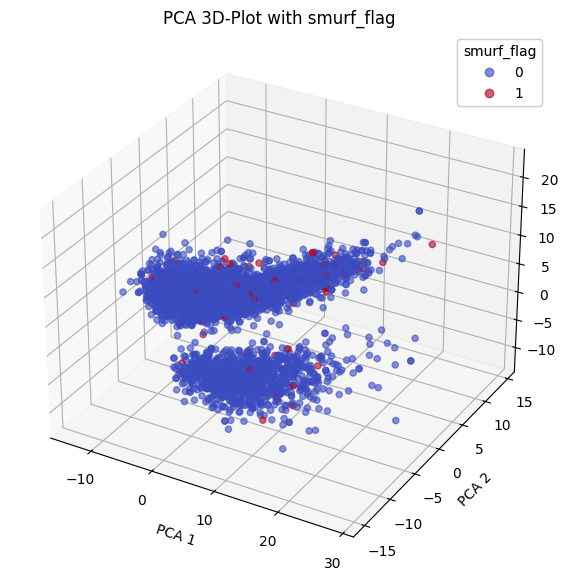

In [6]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], X_test_pca[:, 2], c=y_test, cmap='coolwarm', alpha=0.6)
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
ax.set_title('PCA 3D-Plot with smurf_flag')
legend1 = ax.legend(*scatter.legend_elements(), title="smurf_flag")
ax.add_artist(legend1)
plt.show()